In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [4]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [66]:
projName = "mlve"
experiment = "gestalt_shapegen"
experimentName = f"{experiment}-surface-normals-split-half"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attentionCheck"
batch_idx = "batchIdx"

To download data (@Yoni only), run: 
ssh -i ~/.aws/cocosci_ec2.pem -NL 8000:localhost:27017  ubuntu@ec2-3-90-78-57.compute-1.amazonaws.com

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [67]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [68]:
db.list_collection_names()

['hypersim_v2-depth-estimation-pilot',
 'hypersim_v3-segmentation-split-half',
 'hypersim_v3-depth-estimation-split-half',
 'tdw-segmentation-split-half',
 'gestalt_shapegen_object-loc',
 'tdw-surface-normals-split-half',
 'nsd_surface-normals',
 'gestalt_shapegen-segmentation-split-half',
 'nsd-object-loc-split-half',
 'gestalt_video-object-loc',
 'gestalt_shapegen-depth-estimation-pilot',
 'gestalt_shapegen_video-object-loc',
 'hypersim_surface-normals-splithalf',
 'tdw_surface-normals',
 'nsd-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-split-half',
 'hypersim_surface-normals',
 'gestalt_shapegen-surface-normals-split-half',
 'tdw-depth-estimation-pilot',
 'gestalt_object-loc',
 'tdw-depth-estimation-split-half']

In [69]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             4070 non-null   object 
 1   imageMetadata                   3864 non-null   object 
 2   imageURL                        4041 non-null   object 
 3   trialType                       4041 non-null   object 
 4   trueArrowDirection              4041 non-null   object 
 5   isDuplicate                     4041 non-null   object 
 6   arrowPosition                   4041 non-null   object 
 7   arrowPixelPosition              4041 non-null   object 
 8   randomizeArrowInitialDirection  4041 non-null   object 
 9   attentionCheck                  4041 non-null   object 
 10  batchIdx                        4041 non-null   float64
 11  indicatorFinalDirection         4041 non-null   object 
 12  indicatorDirectionTrajectory    40

In [71]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    if x["response"]["participantComments"] or x["response"]["TechnicalDifficultiesFreeResp"]:
        print(x["response"])

{'TechnicalDifficultiesFreeResp': 'none', 'participantComments': 'none'}
{'TechnicalDifficultiesFreeResp': 'Everything went good', 'participantComments': 'Have a nice day!'}
{'TechnicalDifficultiesFreeResp': "I didn't have any tecknical difficulties", 'participantComments': 'It was a little bit hard'}
{'TechnicalDifficultiesFreeResp': 'I did not encountered any technical dificulties.', 'participantComments': 'Really interesting.'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'It was a very fun and interesting experience!'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'It was pretty hard for me but I hope fot the best. Have a nice day.'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'It was a little hard, but I reallly enjoyed it :)'}
{'TechnicalDifficultiesFreeResp': 'none', 'participantComments': 'had fun yes'}
{'TechnicalDifficultiesFreeResp': "I didn't have issue", 'participantComments': 'it was an interesting experience for sure'}
{'Te

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             4070 non-null   object 
 1   imageMetadata                   3864 non-null   object 
 2   imageURL                        4041 non-null   object 
 3   trialType                       4041 non-null   object 
 4   trueArrowDirection              4041 non-null   object 
 5   isDuplicate                     4041 non-null   object 
 6   arrowPosition                   4041 non-null   object 
 7   arrowPixelPosition              4041 non-null   object 
 8   randomizeArrowInitialDirection  4041 non-null   object 
 9   attentionCheck                  4041 non-null   object 
 10  batchIdx                        4041 non-null   float64
 11  indicatorFinalDirection         4041 non-null   object 
 12  indicatorDirectionTrajectory    40

In [73]:
df.drop("trial_type", axis=1, inplace=True)
df.drop("rt", axis=1, inplace=True)
df.drop("response", axis=1, inplace=True)
df.drop("inputid", axis=1, inplace=True)

In [74]:
df.drop(df[df["indicatorFinalDirection"].isna() == True].index, inplace=True)

In [75]:
df.drop(df[df["trueArrowDirection"].apply(lambda x: x == [None, None, None]) == True].index, inplace=True)

In [76]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [77]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [78]:
def draw_circles(ax, locs, size=10, edgecolor="red", facecolor="none", lw=2):
    """
    draws circle patches on an image at specified locations
    """
    for point in locs:
        circ = patches.Circle((point[1], point[0]), size, ec=edgecolor, fc=facecolor, lw=lw)
        ax.add_patch(circ)
    return ax


In [79]:
def cos_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [80]:
def geodesic_dist(a, b):
    a = np.array(a)
    b = np.array(b)
    if not a.shape or not b.shape:
        print("No data for: ", a, b)
        return float("nan")

    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    dist = np.arccos(a.dot(b))
    return dist

### Check user consistency

In [81]:
potential_fails = []
for user, rows in df.groupby("userID"):
    attention_checks = rows[rows[attention_check]]
    ifd = attention_checks["indicatorFinalDirection"].values
    tad = attention_checks["trueArrowDirection"].values
    
    dists = [geodesic_dist(a, b) for a, b in zip(ifd, tad)]
    score = np.mean(dists)
    if score > 1:
        print(user, score)
        potential_fails.append(user)
print(potential_fails)

5bc4f0d3d1916f0001859f31 1.918127281285729
5c5b77c803dbc1000191ffe6 1.0686174004806224
5e4dc0e1506e2f222ce980be 1.0519857422787189
5ee1216a2a8a214e2ac6fb8b 1.5398519891191338
60e1e6ee3ae500a4fdb7d55e 1.0021759747575048
612fc461a76c1f0212fb3ac2 1.2343713114684154
613a9492023e2c60404e3881 1.695878472824121
6159f374775d59d2d693b20e 1.082209031516174
['5bc4f0d3d1916f0001859f31', '5c5b77c803dbc1000191ffe6', '5e4dc0e1506e2f222ce980be', '5ee1216a2a8a214e2ac6fb8b', '60e1e6ee3ae500a4fdb7d55e', '612fc461a76c1f0212fb3ac2', '613a9492023e2c60404e3881', '6159f374775d59d2d693b20e']


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [82]:
def l2_distance(a, b):
    return np.mean((np.array(a) - np.array(b)) ** 2)

In [83]:
df["geodesic_distance"] = df.apply(lambda x: geodesic_dist(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["cosine_similarity"] = df.apply(lambda x: cos_similarity(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["l2_distance"] = df.apply(lambda x: l2_distance(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)

In [84]:
for user in potential_fails:
    print(df[df["userID"] == user]["geodesic_distance"].mean(), user)

1.2886442280363226 5bc4f0d3d1916f0001859f31
1.275054337930145 5c5b77c803dbc1000191ffe6
1.1967274726469606 5e4dc0e1506e2f222ce980be
1.4725484313628143 5ee1216a2a8a214e2ac6fb8b
1.3391611823150356 60e1e6ee3ae500a4fdb7d55e
1.0631739632896304 612fc461a76c1f0212fb3ac2
1.41465353926973 613a9492023e2c60404e3881
1.143433276212543 6159f374775d59d2d693b20e


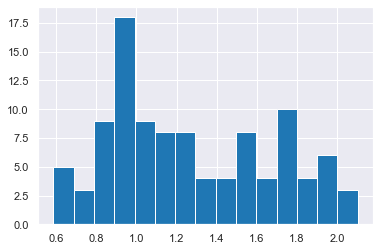

In [85]:
geo_errors = []
n_users = 0
for user, rows in df.groupby("imageURL"):
    geo_errors.append(rows["geodesic_distance"].mean())
    n_users += 1
    
plt.hist(geo_errors, bins=15)
plt.show()
    

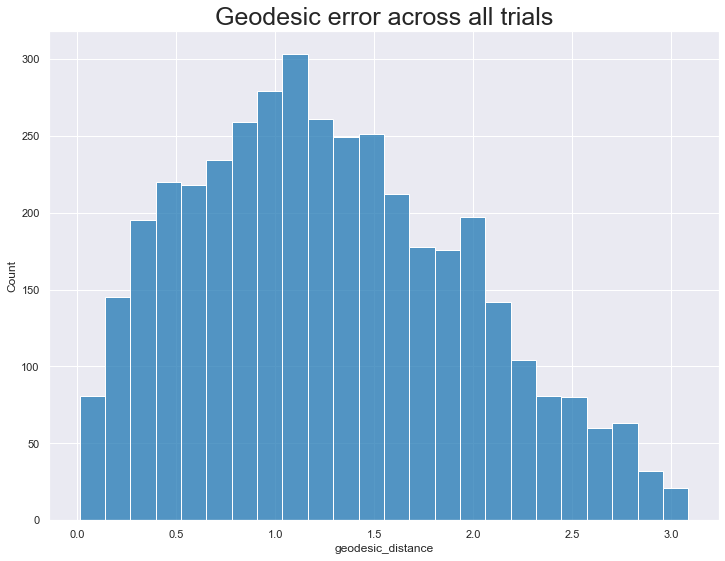

In [86]:

fig, axs = plt.subplots(1, 1, figsize=(12,9))
sns.histplot(df["geodesic_distance"], ax=axs)
# sns.histplot(df["cosine_similarity"], ax=axs[1])

axs.set_title(f"Geodesic error across all trials", fontsize=25)
# axs[1].set_title(f"Cosine similarity across all trials", fontsize=25)
# plt.suptitle(f"{experimentName}")

plt.show()

# Generate cleaned version

In [87]:
df.head()

,_id,imageMetadata,imageURL,trialType,trueArrowDirection,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,...,gameid,iterationName,projName,expName,sessionID,studyID,userID,geodesic_distance,cosine_similarity,l2_distance
0,63179782f88498f33731c717,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.33270063996315, 0.4425165057182312, 0.7511...",False,"[-3.316477495107632, -1.3726810176125244, 0]","[90, 187]",True,False,...,2598-52d1647b-d3b5-4e96-96ea-b8004d9a25b4,v1-full,mlve,gestalt_shapegen-surface-normals-split-half,63179696aa7abd14fd7d1f03,63179660baa2394d656518bd,5f11c12b2cd39e07d04bdb2e,0.666034,0.786278,0.134442
1,631797baf88498f33731c718,NaN,https://mlve-v1.s3.us-east-2.amazonaws.com/att...,unsupervised,"[-0.03086138907129517, 0.8785541802709403, 0.4...",False,"[-0.11021526418786731, -1.8135420743639923, 0]","[165, 250]",True,True,...,6537-487b51bd-6012-40f6-ab4f-a0499f948c0f,v1-full,mlve,gestalt_shapegen-surface-normals-split-half,631796a0615f24b1c252f84c,63179660baa2394d656518bd,60e1e6ee3ae500a4fdb7d55e,1.085826,0.466182,0.355879
2,631797c2f88498f33731c719,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.7668410539627075, 0.4691354036331177, -0.4...",True,"[0.19037181996086083, 0.490958904109589, 0]","[265, 280]",True,False,...,2185-7b8b395d-0a26-4a8e-b445-96b2294e6793,v1-full,mlve,gestalt_shapegen-surface-normals-split-half,6317968ccdfc5d9a1ebbd902,63179660baa2394d656518bd,5f08c06fb722b71194468238,2.265745,-0.640346,1.093524
3,631797ccf88498f33731c71a,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.856380045413971, 0.4814104437828064, 0.186...",False,"[2.5149119373776907, 2.194285714285714, 0]","[381, 365]",True,False,...,6537-487b51bd-6012-40f6-ab4f-a0499f948c0f,v1-full,mlve,gestalt_shapegen-surface-normals-split-half,631796a0615f24b1c252f84c,63179660baa2394d656518bd,60e1e6ee3ae500a4fdb7d55e,0.827161,0.676968,0.215327
4,631797ddf88498f33731c71b,{'objects': {'h1_0': {'shape_type': 'ShapeGene...,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,unsupervised,"[-0.7279513478279114, 0.6316229104995728, -0.2...",False,"[1.3526418786692762, 2.094090019569472, 0]","[323, 360]",True,False,...,6537-487b51bd-6012-40f6-ab4f-a0499f948c0f,v1-full,mlve,gestalt_shapegen-surface-normals-split-half,631796a0615f24b1c252f84c,63179660baa2394d656518bd,60e1e6ee3ae500a4fdb7d55e,2.483904,-0.791407,1.194172


In [88]:
participants = df.groupby("userID")
participants_failed = []
i = 0 
batch_idxs = []
for index, user_results in participants:
    i += 1
    batch_idxs.append(user_results.iloc[0][batch_idx])
    
    if len(user_results) < 100:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not finish the experiment")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    if user_results["geodesic_distance"].mean() > 1.5:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not do too well")
        continue
        
    attention_checks = user_results[user_results[attention_check]] == True
    attention_score = attention_checks["geodesic_distance"].mean()
    if attention_score > 1:
        print("USER ID: " + user_results["userID"].iloc[0] + "scored: " + attention_score)
        participants_failed.append(user_results["userID"].iloc[0])

print(participants_failed)

# failed_participants = df["userID"].apply(lambda x: x in participants_failed)
# df = df[~failed_participants]
# attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
# df = df[~attention_checks]

# my_data = df["userID"] == "yoni_test2"
# df = df[~my_data]

USER ID: 5e3eda0aaa21c6126cfe8d09 did not finish the experiment
USER ID: 5f11c12b2cd39e07d04bdb2e did not finish the experiment
USER ID: 60e4c15e2016f8da7814f75e did not finish the experiment
USER ID: 60ed6ef739959cc28d143526 did not do too well
USER ID: 611ce3570a53282a7597ee62 did not finish the experiment
USER ID: 6131e8440a4cc21f5f839e08 did not finish the experiment
USER ID: 61508119c3a75bea2642d6fd did not finish the experiment
['5e3eda0aaa21c6126cfe8d09', '5f11c12b2cd39e07d04bdb2e', '60e4c15e2016f8da7814f75e', '611ce3570a53282a7597ee62', '6131e8440a4cc21f5f839e08', '61508119c3a75bea2642d6fd']


In [89]:
attention_indexes = df[df[attention_check] == True].index
df.drop(attention_indexes, axis=0, inplace=True)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 0 to 4068
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             3864 non-null   object 
 1   imageMetadata                   3864 non-null   object 
 2   imageURL                        3864 non-null   object 
 3   trialType                       3864 non-null   object 
 4   trueArrowDirection              3864 non-null   object 
 5   isDuplicate                     3864 non-null   object 
 6   arrowPosition                   3864 non-null   object 
 7   arrowPixelPosition              3864 non-null   object 
 8   randomizeArrowInitialDirection  3864 non-null   object 
 9   attentionCheck                  3864 non-null   object 
 10  batchIdx                        3864 non-null   float64
 11  indicatorFinalDirection         3864 non-null   object 
 12  indicatorDirectionTrajectory    38

# split half reliability

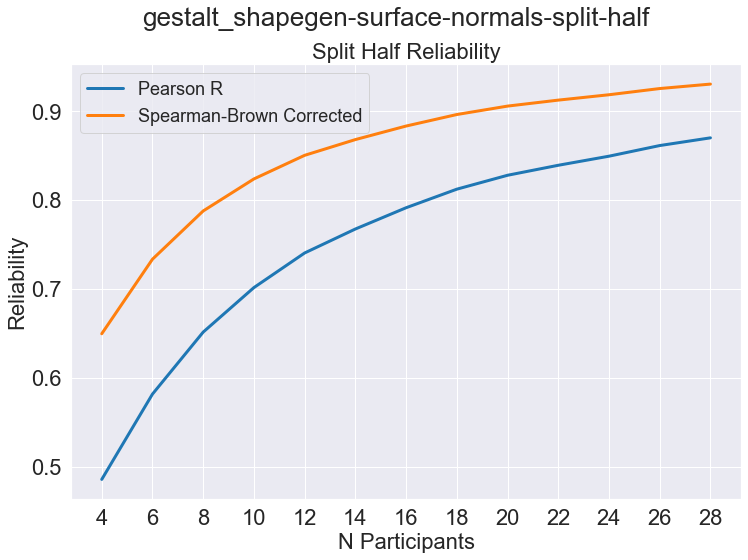

In [91]:
# Split data by user
# For each trial correlate half and half splits
from scipy.stats import pearsonr, sem

def calculate_splithalf(split_num):
    """
    split_num: int: number of participants to sample for each half (ie; if split_num is 5, you choose 5 people for group A and 5 for group B)
    """
    trials = [x[1].values[:28] for x in df.groupby("imageURL")["l2_distance"]]
    trials = np.stack(trials, axis=0) # Gives us a (n_trials, m_participants) array of errors (in our case [100, 38])

    n_participants = trials.shape[1]
    
    pearson_rs = []
    spb_rs = [] # Spearman-Brown corrected Pearson R values
    p_vals = []

    # Take 1000 random splits of participants
    splits = 1000

    for i in range(splits):
        idxs = np.random.choice(range(n_participants), split_num * 2, replace=False)
        a_idxs, b_idxs = np.split(idxs, 2)
        
        a_errs = trials[:, a_idxs].mean(axis=1) # average errors across images
        b_errs = trials[:, b_idxs].mean(axis=1)

        stat, p_val = pearsonr(a_errs, b_errs)
        p_vals.append(p_val)
        pearson_rs.append(stat)
        
        # Spearman-Brown correction = (n*p)/(1 + (n-1)*p) 
        # For split-half n=2 tests
        spb_rs.append((2 * stat) / (1 + stat))

#     print(f"Testing split of {split_num} participants against remainder of population."\
#           f"\nR\t=\t{np.mean(reliabilities)},"\
#           f"\nStd Err\t=\t{sem(reliabilities)}"
#           f"\nP-value\t=\t{np.mean(p_vals)}")
    
    return np.mean(pearson_rs), np.mean(spb_rs)

fig = plt.figure(figsize=(12,8))
rs = []
spbs = []
nparticipants = 15
split_nums = list(range(2, nparticipants))
for split_num in split_nums:
    r, spb = calculate_splithalf(split_num)
    spbs.append(spb)
    rs.append(r)

plt.yticks(fontsize=22)
plt.xticks(range(2, nparticipants), [n * 2 for n in split_nums], fontsize=22)
plt.plot(split_nums, rs, lw=3, label="Pearson R")
plt.plot(split_nums, spbs, lw=3, label="Spearman-Brown Corrected")
plt.xlabel("N Participants", fontsize=22)
plt.ylabel("Reliability", fontsize=22)
plt.legend(fontsize=18)
plt.title("Split Half Reliability", fontsize=22)
plt.suptitle(f"{experimentName}")
plt.show()

# To-Do:

2. Check consistency
3. Rank participants by score
4. Check which trials had the lowest score

## Visualization Ideas

4. Each image w/ probe locations --> put em in a zip
3. Heatmap on a sphere?
1. Download image -- overlay subject estimates with arrow
6. Correlate (X, Y) with estimate + error
5. NSD --> Check participant distribution (histogram, heatmap)
7. Surface normal UNet / model?

### long shot vis
1. Compare distribution of histograms across datasets

## Plot the distribution of surface normals

In [279]:
indicator_directions = np.array([x for x in df["indicatorFinalDirection"]])
true_directions = np.array([x for x in df["trueArrowDirection"]])

In [310]:
### from tqdm.notebook import tqdm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=geodesic_dist(p, pj)
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

def calculate_heatmap(pointList, threshold=0.5):

    u = np.linspace( 0, 2 * np.pi, 20)
    v = np.linspace( 0, np.pi, 20)

    # create the sphere surface
    XX = np.outer( np.cos( u ), np.sin( v ) )
    YY = np.outer( np.sin( u ), np.sin( v ) )
    ZZ = np.outer( np.ones( np.size( u ) ), np.cos( v ) )

    pbar = tqdm(total = len(XX) * len(XX[0]))

    WW = XX.copy()
    for i in range( len( XX ) ):
        for j in range( len( XX[0] ) ):
            x = XX[ i, j ]
            y = YY[ i, j ]
            z = ZZ[ i, j ]

            dist = near(np.array( [x, y, z ] ), pointList, threshold)
            WW[ i, j ] = dist
            pbar.update(1)

    heatmap = WW / np.amax( WW )
    return heatmap, (XX, YY, ZZ)

In [311]:
participant_heatmap, participant_coords = calculate_heatmap(indicator_directions)
if experimentName != "nsd_surface-normals":
    gt_heatmap, true_coords = calculate_heatmap(true_directions)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:06<00:00, 57.23it/s]


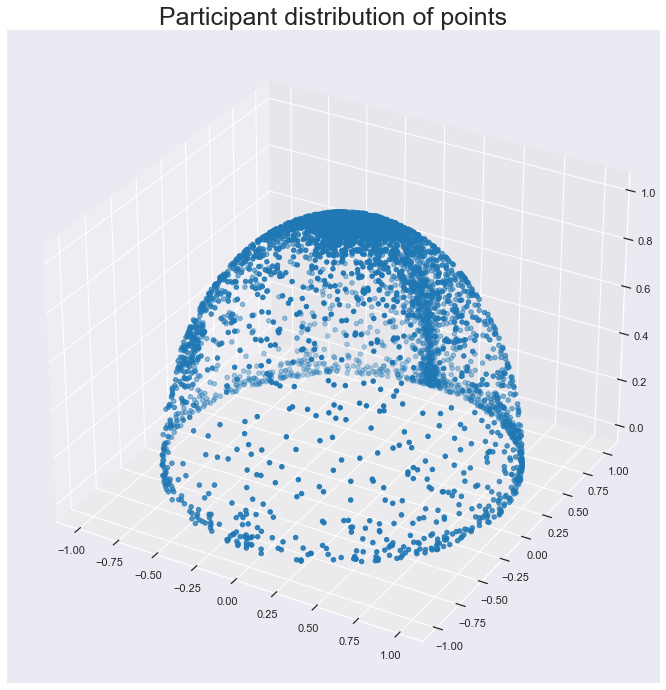

In [312]:
if experimentName != "nsd_surface-normals":

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2])
    ax2.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])

    angle = 45
    degrees = 30
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)
else:
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    ax1.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])


NameError: name 'true_coords' is not defined

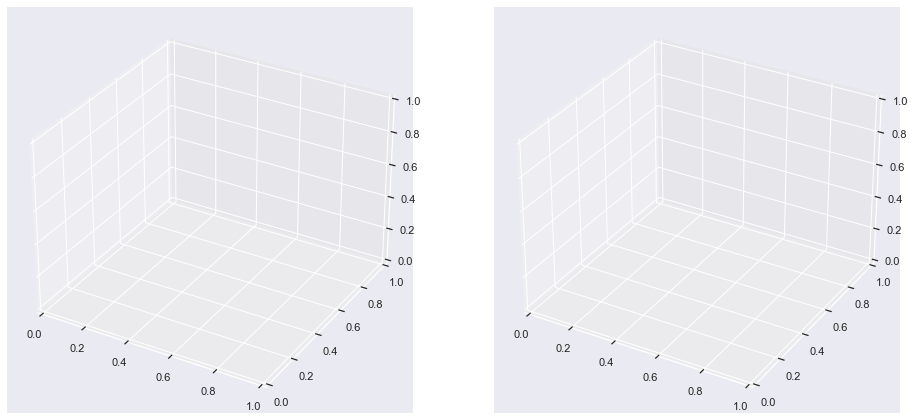

In [414]:
fig = plt.figure(figsize=(16,12))
if experimentName != "nsd_surface-normals":

    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    x, y, z = true_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(gt_heatmap))

    x, y, z = participant_coords
    ax2.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)

    angle = 135
    degrees = 35
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)

    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.825)
    plt.show()
else: 
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    x, y, z = participant_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))
    ax1.set_title("Participant distribution of points", fontsize=25)
    
    angle = 135
    degrees = 35
    ax1.view_init(degrees, angle)
    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.95)
    plt.show()

Text(0.5, 0.98, 'nsd_surface-normals')

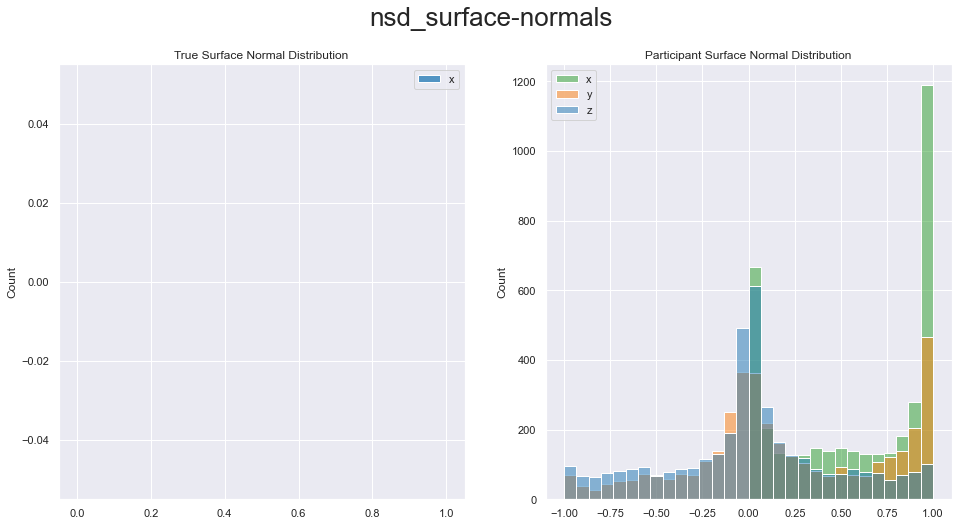

In [302]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
g = sns.histplot(true_directions, ax=axs[0])
axs[0].legend(["x","y","z"])
axs[0].set_title("True Surface Normal Distribution")

g = sns.histplot(indicator_directions, ax=axs[1])
axs[1].legend(["x","y","z"])
axs[1].set_title("Participant Surface Normal Distribution")
plt.suptitle(f"{experimentName}")

## Visualize the distribution of sampled points on images

In [ ]:
plot_images = False

In [ ]:
if plot_images:
    save_dir = os.path.join(f"figures/{experimentName}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("white")
    for url, row in df.groupby("imageURL"):
        point_locs = row["arrowPixelPosition"]
        locs = set()
        for point in point_locs:
            locs.add(tuple(point))

        locs = list(locs)
        image = download_from_url(url)
        plt.close()
        fig,ax = plt.subplots(1, figsize=(12, 12))
        ax.set_aspect('equal')

        ax = draw_circles(ax, locs, size=15, lw=4)
        ax = draw_circles(ax, locs, size=10, lw=4)

        ax.imshow(image)
    #     pixelPositions = row["arrowPixelPosition"]
    #     idfs = row["indicatorFinalDirection"]
    #     for i in range(len(pixelPositions)):
    #         loc = pixelPositions.iloc[i]
    #         ifd = idfs.iloc[i]
    #         r = lambda: np.random.randint(0,255)
    #         color = '#%02X%02X%02X' % (r(),r(),r())
    #         ax.quiver(loc[1], loc[0], ifd[0], ifd[2], scale=ifd[1], color=color, angles="xy", scale_units='y')

        save_title = url.split("/")[-1]
        plt.savefig(os.path.join(save_dir, save_title))
        plt.show()


    sns.set_style("darkgrid")   

In [ ]:
indicator_directions.shape, heatmap.shape

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=participant_heatmap.flatten(),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=3,
                                    color=gt_heatmap.flatten() + np.random.random(3600),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


[[1.         0.30062464]
 [0.30062464 1.        ]]
[[1.         0.26388538]
 [0.26388538 1.        ]]
[[1.         0.15651285]
 [0.15651285 1.        ]]


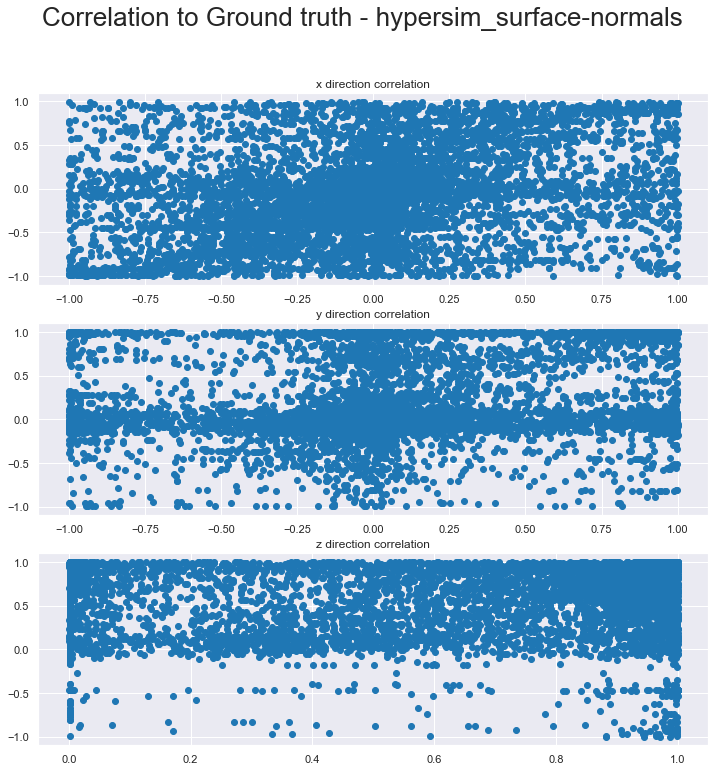

In [119]:
titles = ["x", "y", "z"]
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i in range(3):
    axs[i].scatter(indicator_directions[:, i], true_directions[:, i])
    axs[i].set_title(titles[i] + " direction correlation")
    print(np.corrcoef(indicator_directions[:, i], true_directions[:, i]))
    
    
plt.suptitle("Correlation to Ground truth - " + experimentName)
plt.show()


In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2], color="red", alpha=0.7)
ax.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2], color="blue")

plt.show()

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="blue",
                                    size=5,
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})
fig.show()

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="red",
                                    size=5,
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})



fig.show()


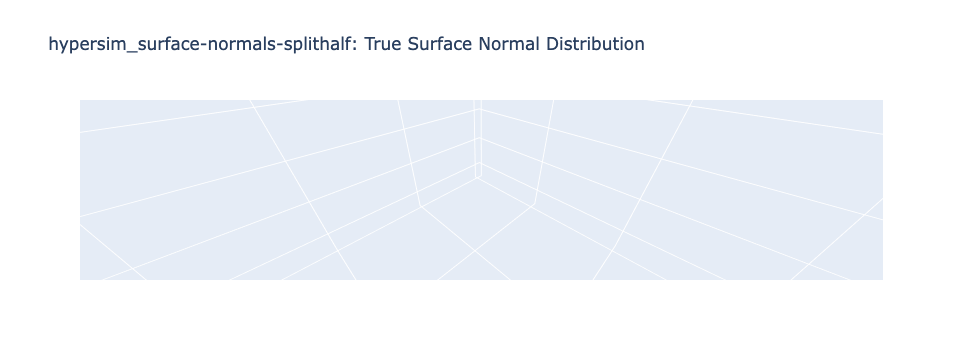

In [92]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=true_directions[:, 0],                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

NameError: name 'XX' is not defined

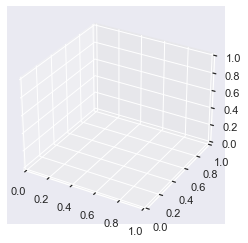

In [93]:
fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( heatmap ) )
plt.show() 


In [94]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=heatmap,                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

NameError: name 'heatmap' is not defined

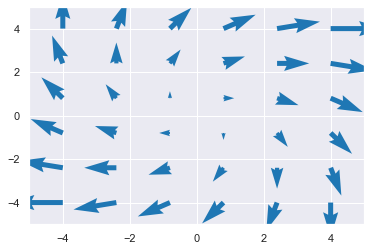

In [95]:
x = np.linspace(-4, 4, 6)
y = np.linspace(-4, 4, 6)
X, Y = np.meshgrid(x, y)
U = X + Y
V = Y - X

# plot
fig, ax = plt.subplots()

ax.quiver(X, Y, U, V, color="C0", angles='xy',
          scale_units='xy', scale=5, width=.015)

ax.set(xlim=(-5, 5), ylim=(-5, 5))

plt.show()